Here, we will merely perform a paired t-test / wilcoxon test to test the differences between the age-sex matched subjects.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Perform-standard-paired-statistical-analysis-on-the-metabolomics-datasets." data-toc-modified-id="Perform-standard-paired-statistical-analysis-on-the-metabolomics-datasets.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Perform standard paired statistical analysis on the metabolomics datasets.</a></span><ul class="toc-item"><li><span><a href="#Noto" data-toc-modified-id="Noto-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Noto</a></span></li><li><span><a href="#Needham" data-toc-modified-id="Needham-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Needham</a></span></li><li><span><a href="#Kuwabara" data-toc-modified-id="Kuwabara-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Kuwabara</a></span></li><li><span><a href="#Kang-2020" data-toc-modified-id="Kang-2020-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Kang 2020</a></span></li></ul></li><li><span><a href="#Compare-against-metabolic-network-from-cross-sectional-cohort." data-toc-modified-id="Compare-against-metabolic-network-from-cross-sectional-cohort.-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Compare against metabolic network from cross-sectional cohort.</a></span></li></ul></div>

In [1]:
import os
import biom
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy.stats import wilcoxon, ttest_rel, mannwhitneyu, ttest_ind
from matplotlib_venn import venn2, venn3
from adjustText import adjust_text
import seaborn as sns
%matplotlib inline


def standard_test(data, group, reference=None, func=mannwhitneyu, mean_norm=False):
    """ Performs standard statistical test"""
    if mean_norm:
        med = data.mean(axis=1)
        data = data / data.mean(axis=1).values.reshape(-1, 1)
    if reference is None:
        reference = group.values[0]
    # extract groups
    groups = (group == reference)
    groupA, groupB = data.loc[groups], data.loc[~groups]
    def _func(feature_id):
        if np.allclose(groupA[feature_id].values, groupB[feature_id].values):
            return 1
        else:
            _, p = func(groupA[feature_id].values, groupB[feature_id].values)
        return p
    pvalues = list(map(_func, data.columns))
    corrected_pvals = multipletests(pvalues, method='fdr_bh')[1]
    return pd.DataFrame({'pvalues': pvalues, 'corrected_pvalues': corrected_pvals}, 
                         index=data.columns)    
    
def paired_test(data, matchings, group, reference=None, func=wilcoxon, mean_norm=False):
    """ Performs paired testing
    
    Parameters
    ----------
    data : pd.DataFrame
        Table of counts (samples x features)
    matchings : pd.Series
        Matching assignments
    group : pd.Series
        Treatment assignments
    func : callable
        The paired statistical test to perform. The paired test
        must return a statistic and a pvalue
    median_norm : bool
        If specified, this will rescale the data around the median
    """
    if mean_norm:
        med = data.mean(axis=1)
        data = data / data.mean(axis=1).values.reshape(-1, 1)
        
    if reference is None:
        reference = group.values[0]
    # extract groups
    groups = (group == reference)
    groupA, groupB = data.loc[groups], data.loc[~groups]
    # pull out matchings and sort them
    matchingA = matchings.loc[groupA.index].sort_values()
    matchingB = matchings.loc[groupB.index].sort_values()
    # order groups by their match id
    groupA = groupA.loc[matchingA.index]
    groupB = groupB.loc[matchingB.index]
    # perform paired test
    def _paired_func(feature_id):
        if np.allclose(groupA[feature_id].values, groupB[feature_id].values):
            return 1
        else:
            _, p = func(groupA[feature_id].values, groupB[feature_id].values)
        return p
    
    def _paired_stat(feature_id):
        t = np.log(np.mean(groupA[feature_id].values)) - np.log(np.mean(groupB[feature_id].values))
        return t
    
    pvalues = list(map(_paired_func, data.columns))
    stat = list(map(_paired_stat, data.columns))
    corrected_pvals = multipletests(pvalues, method='fdr_bh')[1]
    return pd.DataFrame({
        'stat': stat, 'pvalues': pvalues, 'corrected_pvalues': corrected_pvals}, 
        index=data.columns)

# this method is now dated
def fetch_keggs_from_names(pvalues, column = 'pvalues', alpha=0.05):
    url = r'http://cts.fiehnlab.ucdavis.edu/service/convert/Chemical Name/KEGG/%s'
    pairs = []
    for i, n in enumerate(pvalues.index):
        u = url % n
        #if pvalues.loc[n, column] > alpha: continue
        try:
            response = requests.get(u)
            d = response.json()
            print(d)
            for k in d[0]['result']:
                pairs.append((n, k))
        except:
            continue
    return pairs
    
data_dir = '~/ceph/sfari/data/metabolomics'

# Perform standard paired statistical analysis on the metabolomics datasets.

## Noto

In [2]:
noto_md = pd.read_table(
    os.path.join(data_dir, 'Noto2014', 'urine_sample_metadata.txt'), 
    index_col=0, comment='#')
noto_table = biom.load_table('../sfari/data/metabolomics/Noto2014/urine.biom')
noto_table = noto_table.to_dataframe().T

pvalues = paired_test(noto_table, 
                      noto_md['Match_IDs'], 
                      noto_md['Status'], reference='Control', 
                      func=ttest_rel)
pvalues.sort_values('pvalues').head(10)

,stat,pvalues,corrected_pvalues
Leucine,-0.439624,0.001168,0.113715
Tryptophan,-0.780156,0.001961,0.113715
Cystine,-0.868389,0.003014,0.116541
Uric acid,0.723696,0.004272,0.123891
Tyrosine,-0.646183,0.006405,0.125355
3-Aminoisobutyric acid,-0.997303,0.006484,0.125355
Succinic acid,-0.613289,0.008507,0.139192
Lactic acid,-0.439371,0.009599,0.139192
Phenylalanine,-0.525296,0.011367,0.146511
1-Methylhistidine,-0.487423,0.016191,0.178885


In [3]:
lookup = pd.read_csv('../sfari/data/metabolomics/Noto2014/name_map.csv', index_col=0)
pvalues = pd.merge(pvalues, lookup, left_index=True, right_index=True)
#pvalues = pvalues.loc[pvalues.pvalues < 0.05]
pvalues.to_csv('../results/metabolomics/noto2014_urine_pvalues.csv')

## Needham

In [4]:
needham_md = pd.read_table(
    os.path.join(data_dir, 'Needham2020', 'plasma_sample_metadata.txt'), 
    index_col=0, comment='#')
needham_table = biom.load_table('../sfari/data/metabolomics/Needham2020/plasma.biom')
needham_table = needham_table.to_dataframe().T
plasma_metabolite_md = pd.read_table(
    os.path.join(data_dir, 'Needham2020', 'plasma_metabolite_metadata.txt'), 
    index_col=0)

pvalues = paired_test(needham_table, 
                      needham_md['Match_IDs'], 
                      needham_md['Status'], reference='Control', 
                      func=ttest_rel, mean_norm=True)
pvalues.sort_values('pvalues').head(10)

<ipython-input-1-ce91fe692a08>:77: RuntimeWarning: divide by zero encountered in log
  t = np.log(np.mean(groupA[feature_id].values)) - np.log(np.mean(groupB[feature_id].values))
<ipython-input-1-ce91fe692a08>:77: RuntimeWarning: invalid value encountered in double_scalars
  t = np.log(np.mean(groupA[feature_id].values)) - np.log(np.mean(groupB[feature_id].values))


,stat,pvalues,corrected_pvalues
Total CE,0.148996,0.000027,0.038249
LPC(14:0),0.535343,0.000058,0.038249
CE(18:1),0.140311,0.000097,0.038249
CE(20:1),0.138103,0.000098,0.038249
DAG(16:1/18:1),0.230990,0.000122,0.038249
DAG(14:1/18:1),0.214557,0.000143,0.038249
CE(18:2),0.163022,0.000195,0.038249
LPC(15:0),0.482269,0.000197,0.038249
LPC(18:3),0.386570,0.000267,0.038249
CE(18:3),0.335348,0.000273,0.038249


In [5]:
plasma_metabolite_md = plasma_metabolite_md.set_index('BIOCHEMICAL')
pvalues = pd.merge(pvalues, plasma_metabolite_md, left_index=True, right_index=True)
pvalues = pvalues.dropna(subset=['KEGG'])
#pvalues = pvalues.loc[pvalues.pvalues < 0.05]
pvalues.to_csv('../results/metabolomics/needham2020_plasma_pvalues.csv')

In [6]:
pvalues = standard_test(needham_table, 
                        needham_md['Status'], reference='Control', 
                        func=mannwhitneyu, mean_norm=True)
pvalues.sort_values('pvalues').head(10)

,pvalues,corrected_pvalues
DAG(16:1/18:1),0.000005,0.007550
DAG(14:1/18:1),0.000014,0.007793
CE(18:3),0.000015,0.007793
LPC(17:0),0.000024,0.008208
Total CE,0.000026,0.008208
TAG53:6-FA18:2,0.000031,0.008208
TAG44:0-FA18:0,0.000036,0.008208
LPC(20:3),0.000042,0.008208
LPC(14:0),0.000046,0.008208
LPC(18:3),0.000071,0.011390


In [7]:
needham_md = pd.read_table(
    os.path.join(data_dir, 'Needham2020', 'fecal_sample_metadata.txt'), 
    index_col=0, comment='#')
needham_table = biom.load_table('../sfari/data/metabolomics/Needham2020/fecal.biom')
needham_table = needham_table.to_dataframe().T
fecal_metabolite_md = pd.read_table(
    os.path.join(data_dir, 'Needham2020', 'fecal_metabolite_metadata.txt'), 
    index_col=0)

pvalues = paired_test(needham_table, 
                      needham_md['Match_IDs'], 
                      needham_md['Status'], reference='Control', 
                      func=ttest_rel, mean_norm=True)
pvalues.sort_values('pvalues').head(10)

<ipython-input-1-ce91fe692a08>:77: RuntimeWarning: divide by zero encountered in log
  t = np.log(np.mean(groupA[feature_id].values)) - np.log(np.mean(groupB[feature_id].values))
<ipython-input-1-ce91fe692a08>:77: RuntimeWarning: invalid value encountered in double_scalars
  t = np.log(np.mean(groupA[feature_id].values)) - np.log(np.mean(groupB[feature_id].values))


,stat,pvalues,corrected_pvalues
1-palmitoleoylglycerol (16:1)*,0.968343,0.004947,0.91114
hydroxymethylpyrimidine,-0.535911,0.009271,0.91114
3-aminoisobutyrate,-1.697476,0.015656,0.91114
2-palmitoylglycerol (16:0),0.592031,0.021914,0.91114
3-(4-hydroxyphenyl)lactate,-0.725636,0.023689,0.91114
2-palmitoleoylglycerol (16:1)*,1.156097,0.026556,0.91114
retinol (Vitamin A),-1.168096,0.026714,0.91114
ribitol,0.456251,0.026797,0.91114
lignoceroyl ethanolamide (24:0)*,-0.504284,0.031249,0.91114
I-urobilinogen,-1.619834,0.032106,0.91114


In [8]:
fecal_metabolite_md = fecal_metabolite_md.set_index('BIOCHEMICAL')
pvalues = pd.merge(pvalues, fecal_metabolite_md, left_index=True, right_index=True)
pvalues = pvalues.dropna(subset=['KEGG'])
#pvalues = pvalues.loc[pvalues.pvalues < 0.05]
pvalues.to_csv('../results/metabolomics/needham2020_fecal_pvalues.csv')

In [9]:
pvalues = standard_test(needham_table, 
                        needham_md['Status'], reference='Control', 
                        func=mannwhitneyu, mean_norm=True)
pvalues.sort_values('pvalues').head(10)

,pvalues,corrected_pvalues
retinol (Vitamin A),0.000095,0.077478
1-methylurate,0.002173,0.479931
glutamyl-meso-diaminopimelate,0.002947,0.479931
1-oleoyl-GPC (18:1),0.004742,0.479931
1-palmitoleoylglycerol (16:1)*,0.005076,0.479931
1-linoleoyl-GPE (18:2)*,0.005746,0.479931
hydroxymethylpyrimidine,0.006635,0.479931
alpha-tocotrienol,0.007086,0.479931
"uridine-2',3'-cyclic monophosphate",0.007956,0.479931
aconitate [cis or trans],0.008063,0.479931


## Kuwabara

In [10]:
kuwabara_md = pd.read_table(
    os.path.join(data_dir, 'Kuwabara2013', 'plasma_sample_metadata.txt'), 
    index_col=0, comment='#')
kuwabara_table = biom.load_table('../sfari/data/metabolomics/Kuwabara2013/plasma.biom')
kuwabara_table = kuwabara_table.to_dataframe().T

pvalues = paired_test(kuwabara_table, 
                      kuwabara_md['Match_IDs'], 
                      kuwabara_md['Status'], reference='Control', 
                      func=ttest_rel)
pvalues.sort_values('corrected_pvalues').head(10)

<ipython-input-1-ce91fe692a08>:77: RuntimeWarning: divide by zero encountered in log
  t = np.log(np.mean(groupA[feature_id].values)) - np.log(np.mean(groupB[feature_id].values))
<ipython-input-1-ce91fe692a08>:77: RuntimeWarning: invalid value encountered in double_scalars
  t = np.log(np.mean(groupA[feature_id].values)) - np.log(np.mean(groupB[feature_id].values))


,stat,pvalues,corrected_pvalues
C00327,-0.352395,0.003834,0.191480
C00334,-0.528036,0.004959,0.191480
C00008,-1.370473,0.005129,0.191480
"C00062,C00792",-0.266188,0.045981,0.572203
C00022,0.333920,0.029613,0.572203
"C00186,C00256,C01432",0.513937,0.023483,0.572203
C00093,0.164399,0.044621,0.572203
"C00025,C00217,C00302",-0.745064,0.041292,0.572203
"C00065,C00716,C00740",0.106640,0.032531,0.572203
C00002,-inf,0.057531,0.644352


In [11]:
pairs = []
for i, x in enumerate(pvalues.index):
    for k in x.split(','):
        pairs.append((i, k))

pairs = pd.DataFrame(pairs, columns=['idx', 'KEGG'])
pvalues = pvalues.reset_index()
pvalues = pd.merge(pvalues, pairs, left_index=True, right_on='idx')
#pvalues = pvalues[pvalues.pvalues < 0.05]
pvalues = pvalues.set_index('index')

lookup = pd.read_csv('../sfari/data/metabolomics/Kuwabara2013/name_map.csv')
pvalues = pd.merge(pvalues, lookup, left_on='KEGG', right_on='KEGG')
#pvalues = pvalues.loc[pvalues.pvalues < 0.05]
pvalues = pvalues.set_index('Match')
pvalues.to_csv('../results/metabolomics/kuwabara2013_plasma_pvalues.csv')

## Kang 2020

Relevant paper https://pubmed.ncbi.nlm.nih.gov/33087514/

In [12]:
kang_md = pd.read_table(
    os.path.join(data_dir, 'Kang2018', 'fecal_sample_metadata.txt'), 
    index_col=0, comment='#')
kang_table = biom.load_table('../sfari/data/metabolomics/Kang2018/fecal.biom')
kang_table = kang_table.to_dataframe().T

pvalues = paired_test(kang_table, 
                      kang_md['Match_IDs'], 
                      kang_md['Status'], reference='Neurotypical', 
                      func=ttest_rel)
pvalues.sort_values('pvalues').head(10)

<ipython-input-1-ce91fe692a08>:77: RuntimeWarning: divide by zero encountered in log
  t = np.log(np.mean(groupA[feature_id].values)) - np.log(np.mean(groupB[feature_id].values))


,stat,pvalues,corrected_pvalues
Formate,0.269753,0.044261,0.885528
p-Cresol,-0.270504,0.096193,0.885528
Caprate,-0.240665,0.143580,0.885528
Fumarate,0.349768,0.149047,0.885528
Isovalerate,-0.209003,0.158597,0.885528
Nicotinate,0.399701,0.177967,0.885528
Isobutyrate,-0.196820,0.180027,0.885528
Glutamine,0.269853,0.182832,0.885528
Phenylacetate,-0.195894,0.204085,0.885528
Asparagine,2.374246,0.229246,0.885528


In [13]:
lookup = pd.read_csv('../sfari/data/metabolomics/Kang2018/name_map.csv', index_col=0)
pvalues = pd.merge(pvalues, lookup, left_index=True, right_index=True)
#pvalues = pvalues.loc[pvalues.pvalues < 0.05]
pvalues.to_csv('../results/metabolomics/kang2018_fecal_pvalues.csv')

In [14]:
pvalues

,stat,pvalues,corrected_pvalues,Match,HMDB,PubChem,ChEBI,KEGG,METLIN,SMILES,Comment
2-Aminobutyrate,-0.115815,0.689662,0.970436,L-Alpha-aminobutyric acid,HMDB0000452,80283.0,35619,C02356,12.0,CC[C@@H](C(=O)O)N,1
3-Phenylpropionate,0.050962,0.854882,0.970436,Hydrocinnamic acid,HMDB0000764,107.0,28631,C05629,4153.0,OC(=O)CCC1=CC=CC=C1,1
4-Aminobutyrate,0.410941,0.518575,0.956123,Gamma-Aminobutyric acid,HMDB0000112,223130.0,16865,C00334,NaN,NCCCC(=O)O,1
Acetate,0.114421,0.496690,0.945313,Acetic acid,HMDB0000042,176.0,15366,C00033,3206.0,CC(=O)O,1
Alanine,-0.009922,0.969903,0.988653,L-Alanine,HMDB0000161,5950.0,16977,C00041,NaN,C[C@H](N)C(O)=O,1
Arginine,-0.769976,0.258412,0.885528,L-Arginine,HMDB0000517,6322.0,16467,C00062,5502.0,N[C@@H](CCCNC(N)=N)C(O)=O,1
Aspartate,0.002278,0.994823,0.994823,L-Aspartic acid,HMDB0000191,5960.0,17053,C00049,5206.0,N[C@@H](CC(O)=O)C(O)=O,1
Butyrate,0.321647,0.265679,0.885528,Butyric acid,HMDB0000039,264.0,30772,C00246,107.0,CCCC(=O)O,1
Caprate,-0.240665,0.143580,0.885528,Capric acid,HMDB0000511,2969.0,30813,C01571,336.0,CCCCCCCCCC(=O)O,1
Choline,-0.013478,0.971896,0.988653,Choline,HMDB0000097,305.0,15354,C00114,56.0,C[N+](C)(C)CCO,1


# Compare against metabolic network from cross-sectional cohort.

In [15]:
new_pos = pd.read_csv('../results/connected_compound_positions.csv', index_col=0)
rna_compounds = pd.read_csv('../results/RNA_compounds.csv', index_col=0)
wgs_compounds = pd.read_csv('../results/WGS_compounds.csv', index_col=0)
amp_compounds = pd.read_csv('../results/16S_compounds.csv', index_col=0)

rna_logpvals = rna_compounds[['Compound', '-log(pvalue)']].groupby('Compound').mean()
wgs_logpvals = wgs_compounds[['Compound', '-log(pvalue)']].groupby('Compound').mean()
amp_logpvals = amp_compounds[['Compound', '-log(pvalue)']].groupby('Compound').mean()

wgs_pos = pd.merge(new_pos, wgs_logpvals, left_index=True, right_index=True)
amp_pos = pd.merge(new_pos, amp_logpvals, left_index=True, right_index=True)
rna_pos = pd.merge(new_pos, rna_logpvals, left_index=True, right_index=True)

all_pos = pd.concat((wgs_pos, amp_pos, rna_pos))
all_pos = all_pos.reset_index()
all_pos = all_pos.groupby('index').mean()

In [16]:
# load all differential abundance tests
noto_pvalues = pd.read_csv('../results/metabolomics/noto2014_urine_pvalues.csv', index_col=0)
kuwabara_pvalues = pd.read_csv('../results/metabolomics/kuwabara2013_plasma_pvalues.csv', index_col=0)
kang_plasma_pvalues = pd.read_csv('../results/metabolomics/kang2018_fecal_pvalues.csv', index_col=0)
nd_fecal_pvalues = pd.read_csv('../results/metabolomics/needham2020_fecal_pvalues.csv', index_col=0)
nd_plasma_pvalues = pd.read_csv('../results/metabolomics/needham2020_plasma_pvalues.csv', index_col=0)

noto_pvalues['dataset'] = 'Noto'
kuwabara_pvalues['dataset'] = 'Kuwabara'
nd_fecal_pvalues['dataset'] = 'Needham'
nd_plasma_pvalues['dataset'] = 'Needham'
kang_plasma_pvalues['dataset'] = 'Kang'

noto_pvalues['sample_type'] = 'Urine'
kuwabara_pvalues['sample_type'] = 'Plasma'
nd_fecal_pvalues['sample_type'] = 'Fecal'
nd_plasma_pvalues['sample_type'] = 'Plasma'
kang_plasma_pvalues['sample_type'] = 'Fecal'

all_pvalues = pd.concat((noto_pvalues, kuwabara_pvalues, 
                         nd_fecal_pvalues, nd_plasma_pvalues, 
                         kang_plasma_pvalues))
all_pvalues = all_pvalues[['stat', 'pvalues', 'corrected_pvalues', #'Compound_Name', 
                           'KEGG', 'dataset', 'sample_type']]

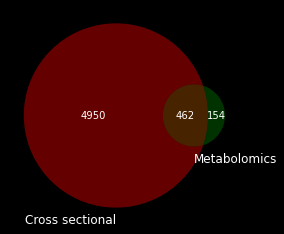

In [17]:
with plt.style.context('dark_background'):
    venn2([set(all_pos.index), set(all_pvalues['KEGG'])], ['Cross sectional', 'Metabolomics'])

In [18]:
all_pos = pd.merge(all_pvalues, all_pos, left_on='KEGG', right_index=True, how='right')
all_pos = all_pos.set_index('KEGG')

In [19]:
def pvalue_f(x):
    if pd.isnull(x):
        return 'Cross-sectional'
    if x < 0.05:
        return 'FDR significant'
    else:
        return 'Reported'
all_pos['Signficance'] = all_pos.corrected_pvalues.apply(pvalue_f)
sub_pos = all_pos.dropna(subset=['sample_type'])

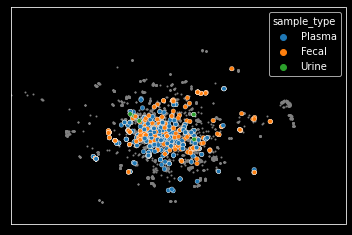

In [20]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots()
    ax.scatter(all_pos['0'], all_pos['1'], s=1, c='gray')
    sns.scatterplot(data=sub_pos, x='0', y='1', hue='sample_type',
                    s=20, palette='tab10', ax=ax)
    ax.set_xlim([-0.11, 0.15])
    ax.set_ylim([-0.11, 0.15])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')    

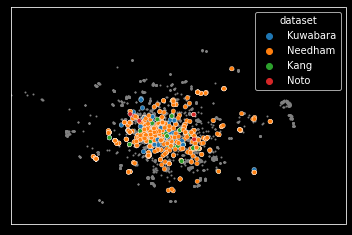

In [21]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots()
    ax.scatter(all_pos['0'], all_pos['1'], s=1, c='gray')
    sns.scatterplot(data=sub_pos, x='0', y='1', hue='dataset',
                    s=20, palette='tab10', ax=ax)
    ax.set_xlim([-0.11, 0.15])
    ax.set_ylim([-0.11, 0.15])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')    

In [22]:
all_pos['Signficance'].value_counts()

Cross-sectional    4950
Reported            795
Name: Signficance, dtype: int64

In [23]:
all_pvalues['-log(pvalue)'] = -np.log(all_pvalues['pvalues'])
all_pvalues['sig'] = all_pvalues['pvalues'] < 0.05

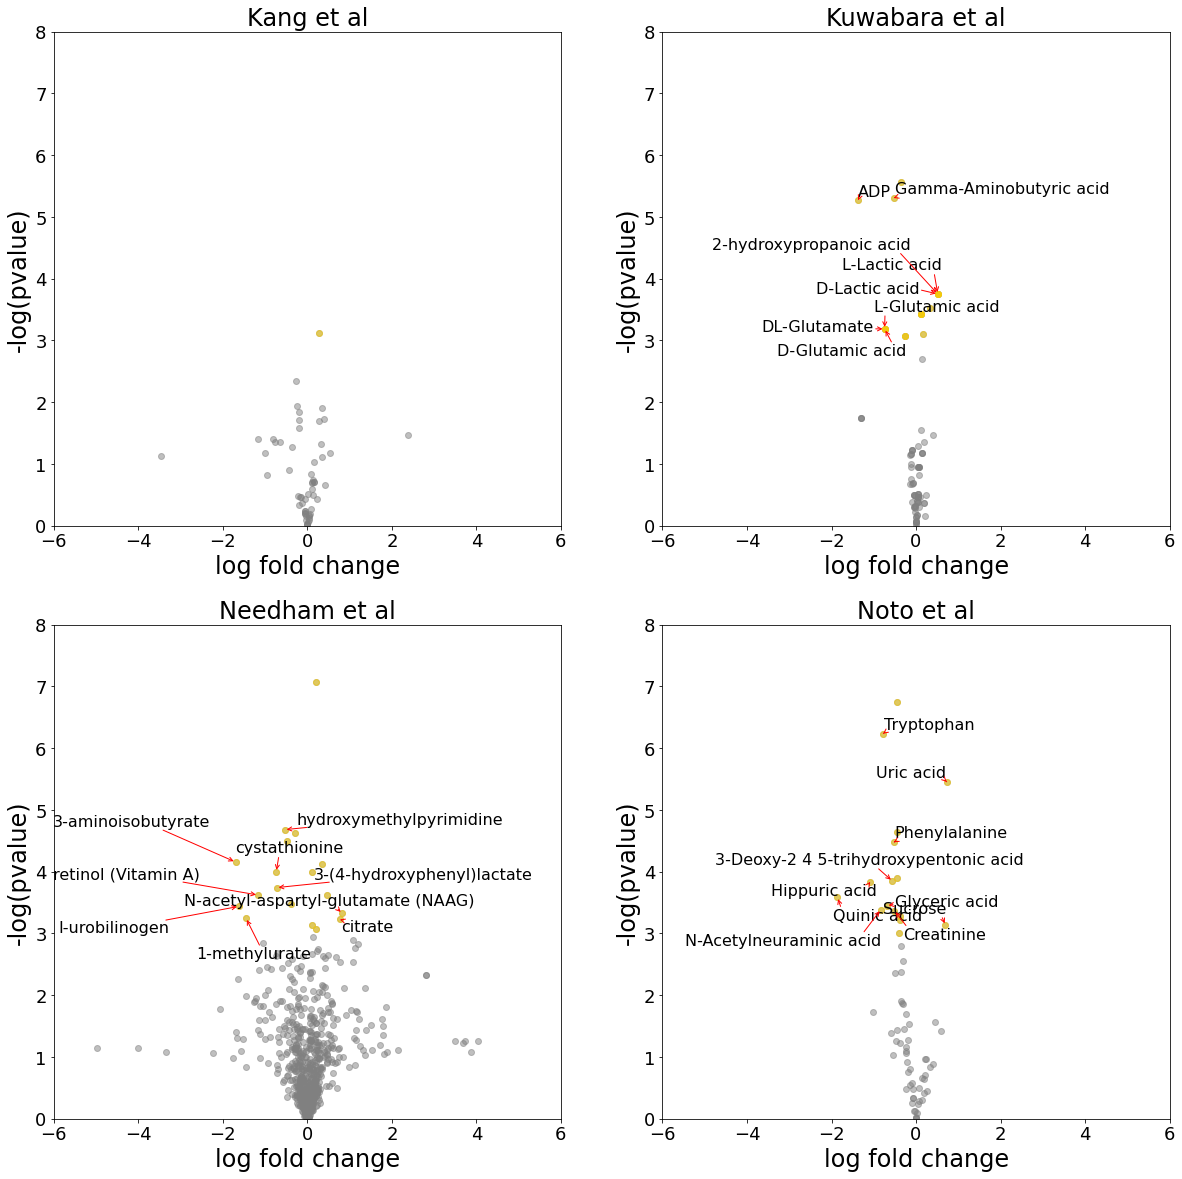

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))

for i, (name, df) in enumerate(all_pvalues.groupby('dataset')):
    u, v = i // 2, i % 2
    #sns.scatterplot(data=df, x='stat', y='-log(pvalue)', ax=ax[i], s=10, hue='sig', legend=False)
    ax[u][v].plot(df['stat'].values, df['-log(pvalue)'], 'o', c='#808080', alpha=0.5)
    idx = df['pvalues'] < 0.05
    ax[u][v].plot(df.loc[idx, 'stat'].values, df.loc[idx, '-log(pvalue)'], 'o', c='#ffd100', alpha=0.5)
    
    ax[u][v].set_title(f'{name} et al', fontsize=24)
    ax[u][v].set_xlabel('log fold change', fontsize=24)
    ax[u][v].set_ylabel('-log(pvalue)', fontsize=24)
    
    idx = np.logical_and(df['pvalues'] < 0.05, np.abs(df['stat']) > 0.5)
    subdf = df.loc[idx]
    x = subdf['stat'].values
    y = subdf['-log(pvalue)'].values
    s = list(subdf.index)
    dx, dy = 0, 0
    texts = [ax[u][v].text(x[j] + dx, y[j] + dy, s[j], #.replace(' ', '\n'), 
                           fontsize=16,
                           ha='center', va='center') 
             for j in range(len(x))]
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'), ax=ax[u][v], 
                expand_text=(1.5, 1.8), 
                #expand_points=(1.5, 1.5), 
                #expand_align=(1.5, 1.5),
                #force_text=(0.6, 1.5),
                #force_objects=(0.6, 1.5),
                precision=0.001, lim=5000)
    ax[u][v].tick_params('x', labelsize=18)
    ax[u][v].tick_params('y', labelsize=18)
    
    ax[u][v].set_ylim([0, 8])
    ax[u][v].set_xlim([-6, 6])